# Постановка задачи
Мы выступим в роли программиста-сомелье: нам предстоит определять качество вина. Необходимо решить задачу классификации с использованием SVM и подобрать наилучшее ядро.

## Данные
Датасет содержит информацию о красных винах и их составе. Целевой переменной является столбец "quality". Это метрика качества вина по шкале от 3 до 8.

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
# загрузка данных
wine_df = pd.read_csv('winequality-red.csv', sep = ';')
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# проверяем пропуски и типы данных
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


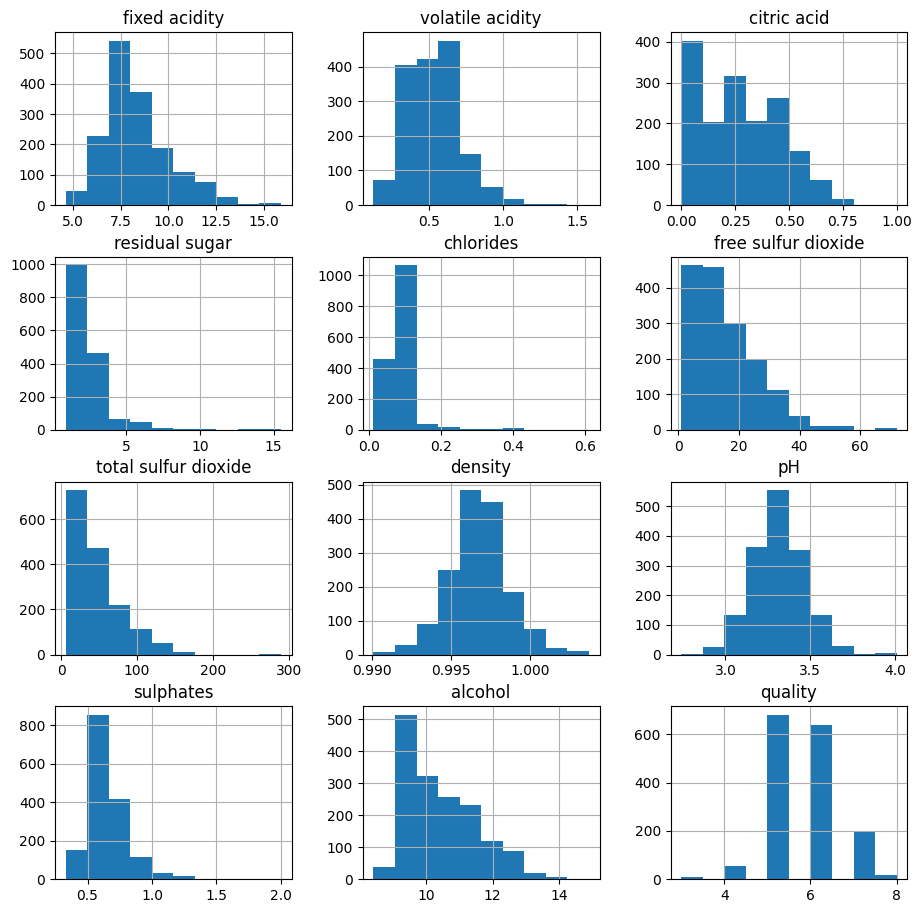

In [4]:
# посмотрим на рспределение переменных
wine_df.hist(figsize = (11, 11));

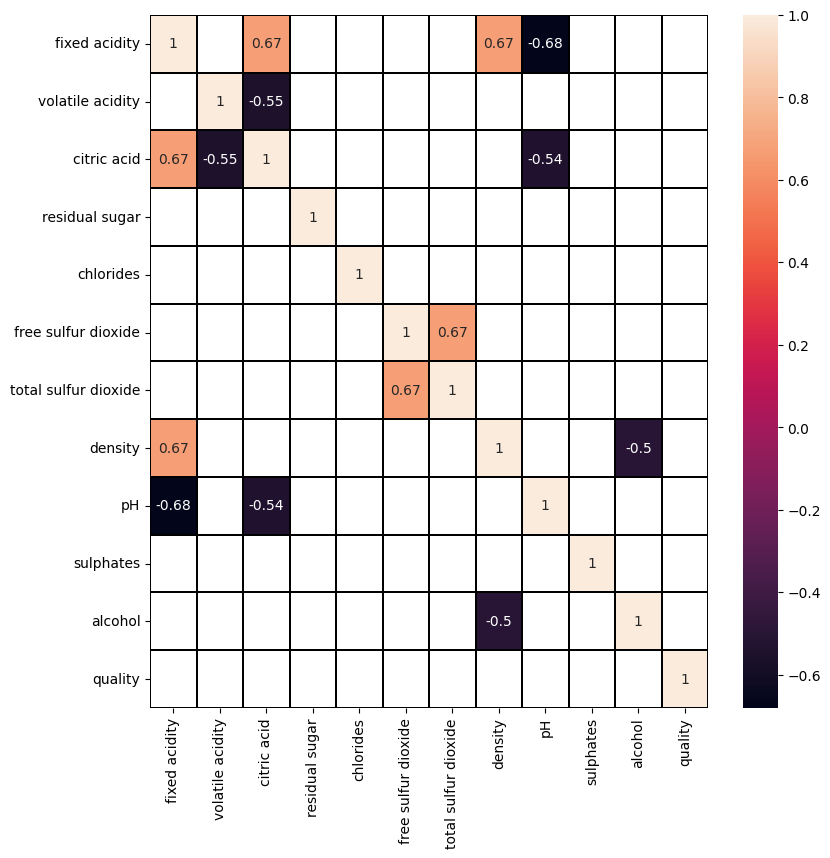

In [5]:
# проверим корреляцию признаков
corr = round(wine_df.corr(), 2)

# выведем только данные с высоким уровнем корреляции
mask_1 = np.abs(corr) >= 0.50
mask_2 = np.abs(corr) <= -0.50
corr_data = corr[mask_1 | mask_2]

# визуализируем
fig = plt.figure(figsize = (9, 9))
sns.heatmap(corr_data, annot = True, linewidth=0.3, linecolor='black');

## Генерация признаков

С помощью метода главных компонент PCA посмотрим на сколько можно сократить коррелирующие между собой признаки 'fixed acidity', 'volatile acidity', 'citric acid', 'density', 'pH' и 'alcohol', чтобы сохранить хотя бы 80% их информативности.

In [6]:
# определяем коррелирующие колонки
corr_features = [
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'density',
    'pH',
    'alcohol'
]

# снижаем размерность
pca = PCA(n_components = 0.8)
pca_components = pca.fit_transform(wine_df[corr_features])

# выводим информацию
print(
    'Количество новых компонент:',
    len(pca.explained_variance_ratio_)
)
print(
    'Информативность новых компонент:',
    np.round(np.sum(pca.explained_variance_ratio_), 4)
)

Количество новых компонент: 2
Информативность новых компонент: 0.9859


Почти 99% - неплохо, добавляем в датафрейм новые признаки, удаляем старые.

In [7]:
wine_df[['pca_1', 'pca_2']] = pca_components
wine_df.drop(corr_features, axis = 1, inplace = True)

In [8]:
# объединяем признаки 'free sulfur dioxide' и 'total sulfur dioxide' в один
sulfur_dioxide = ['free sulfur dioxide', 'total sulfur dioxide']
pca = PCA(n_components = 1)
wine_df['sulfur dioxide'] = pca.fit_transform(wine_df[sulfur_dioxide])
wine_df.drop(sulfur_dioxide, axis = 1, inplace = True)
print(
    'Информативность sulfur dioxide:',
    np.round(np.sum(pca.explained_variance_ratio_), 4)
)

Информативность sulfur dioxide: 0.9514


In [9]:
# проверим корреляцию признаков c таргетом
corr = round(wine_df.corr(), 2)
corr['quality'].abs().sort_values(ascending = False)[1:]

,quality
pca_2,0.49
sulphates,0.25
sulfur dioxide,0.18
chlorides,0.13
pca_1,0.11
residual sugar,0.01


Наилучшую корреляцию показывает одна из наших новых компонент, однако сильной линейной взаимосвязи между нашими признаками и целевой переменной не наблюдается.

Сведём нашу задачу к бинарной классификации сделав целевую переменную категориальной ('bad wine': quality <= 6.5 и 'good wine': quality > 6.5).

In [10]:
wine_df['quality'] = wine_df['quality'].apply(
    lambda x: 1 if x > 6.5 else 0
).astype('category')
wine_df['quality'].value_counts(normalize = True)

,proportion
quality,
0,0.86429
1,0.13571


Классы распредлены не равномерно.

## Подбор гиперпараметров и обучение модели

Для решения задачи будем использовать метод опорных векторов (SVM) с ядром, который преобразует исходную нелинейную задачу в линейную в многомерном пространстве.

In [11]:
# подготавливаем данные
X = wine_df.drop('quality', axis = 1)
y = wine_df['quality']

# масштабируем данные
scaler = StandardScaler()
X = scaler.fit_transform(X)

Для начала посмотрим как работает логистическая регрессия.

In [12]:
model = LogisticRegression()
cv = cross_val_score(model, X, y, scoring = 'accuracy', cv = 5)
print('Accuracy:', round(cv.mean(), 4))

Accuracy: 0.8662


Как мы выяснили ранее не все признаки иметь линейную зависимость с целевой переменной, но возможно существует нелинейная зависимость. Попробуем SVC с ядром по умолчанию (RBF) - одно из наиболее широко используемых ядер из-за его сходства с распределением Гаусса.

In [13]:
model = SVC()
cv = cross_val_score(model, X, y, scoring = 'accuracy', cv = 5)
print('Accuracy:', round(cv.mean(), 4))

Accuracy: 0.8668


SVC незначительно улучшил результат.

Попробуем настроить гиперпараметры. Подбирать наилучшие параметры будем с помощью GridSearchCV из sklearn.model_selection. Для кросс-валидации будем использовать StratifiedShuffleSplit со стратификацей, так как классы целевого признака не сбалансированы.

In [14]:
# определяем сетку гиперпараметров
C_range = np.logspace(-2, 2, 5)
kernel_type = ['linear', 'rbf', 'sigmoid']
gamma_range = np.logspace(-2, 2, 5)
param_grid = dict(C = C_range, kernel = kernel_type, gamma = gamma_range)

# задаём условия для кросс-валидации
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42)

# перебираем гиперпараметры
gs = GridSearchCV(
    estimator = SVC(),
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = cv
)
gs.fit(X, y)
print('Best params:', gs.best_params_)

Best params: {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}


In [16]:
# рассчитываем метрику
cv = cross_val_score(
    SVC(C = 10, kernel = 'rbf', gamma = 10),
    X,
    y,
    scoring = 'accuracy',
    cv = 5
)
print('Accuracy:', round(cv.mean(), 4))

Accuracy: 0.8674


Метрику получилось улучшить, но снова незначительно. Давайте посмотрим на визуализацию решающей функции с разными параметрами. Для двумерной визуализации возьмём признаки имеющие найменьшую линейную связь с целевой переменной.

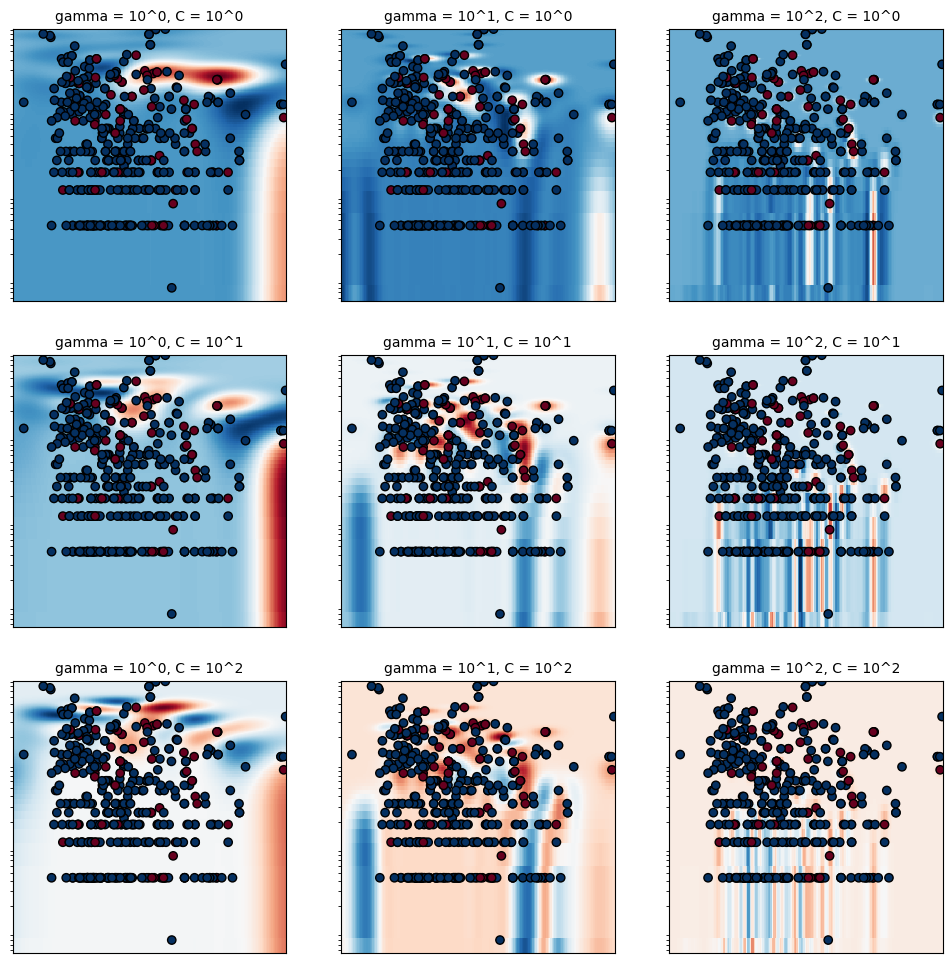

In [20]:
# подготавливаем данные
X_2d = wine_df[['pca_1', 'residual sugar']]
scaler = StandardScaler()
X_2d = scaler.fit_transform(X_2d)
y_2d = y.values

# перебираем параметры
C_2d_range = np.logspace(0, 2, 3)
gamma_2d_range = np.logspace(0, 2, 3)
classifiers = []

for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C = C, kernel = 'rbf', gamma = gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

# визуализация эффекта параметров
plt.figure(figsize = (12, 12))
xx, yy = np.meshgrid(
    np.linspace(np.min(X_2d[:, 0]), np.max(X_2d[:, 0]), 200),
    np.linspace(np.min(X_2d[:, 1]), np.max(X_2d[:, 1]), 200)
)

for (k, (C, gamma, clf)) in enumerate(classifiers):
    # оценим функцию принятия решения в сетке
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # визуализируем функцию принятия решения для этих параметров
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title(
        'gamma = 10^%d, C = 10^%d' % (np.log10(gamma), np.log10(C)),
        size = 'medium'
    )

    # визуализируем влияние параметра на функцию принятия решения
    plt.pcolormesh(xx, yy, -Z, cmap = plt.cm.RdBu)
    plt.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c = y_2d,
        cmap = plt.cm.RdBu_r,
        edgecolors="k",
    )
    plt.gca().set_yscale('log') # логарифмируем ось ординат для наглядности
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

Решающая функция больше не является линейной и стремиться разделять классы более точно.